In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.integrate import quad
import pandas as pd

from pyvbmc import VBMC
import random
import os
from tqdm import tqdm
from V_A_change_utils import Phi

# params

In [2]:
V_A = 1.1
# V_A = 9
theta_A = 1.8

rate_lambda = 0.14
T_0 = 0.66 * (1e-3)
theta_E = 40.5

t_A_aff = 0.05
t_E_aff = 0
t_motor = 0

Z_E = 0
L = 0.5

N_sim = int(500e3)
dt = 1e-4

N_print = int(100e5)

t_stim_0 = 1
# t_stim_0 = 0.5
t_stim_tau = 0.4

T_trunc = 0.1

# simualted data

In [3]:
def psiam_tied_data_gen_wrapper(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, t_motor, L, \
                                t_stim_0, t_stim_tau, iter_num, N_print, dt):
    ABL = random.choice(ABL_arr)
    ILD = random.choice(ILD_arr)
    
    # t_stim is picked from a distribution
    t_stim = np.random.exponential(t_stim_tau) + t_stim_0

    # print after every N_print iterations
    if iter_num % N_print == 0:
        print(f'In iter_num: {iter_num}, ABL: {ABL}, ILD: {ILD}, t_stim: {t_stim}')


    choice, rt, is_act = simulate_psiam_tied(V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, dt)
    return {'choice': choice, 'rt': rt, 'is_act': is_act ,'ABL': ABL, 'ILD': ILD, 't_stim': t_stim}

def simulate_psiam_tied(V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, dt):
    AI = 0; DV = Z_E; t = 0; dB = dt**0.5
    
    chi = 17.37; q_e = 1
    theta = theta_E * q_e
    mu = (2*q_e/T_0) * (10**(rate_lambda * ABL/20)) * np.sinh(rate_lambda * ILD/chi)
    sigma = np.sqrt( (2*(q_e**2)/T_0) * (10**(rate_lambda * ABL/20)) * np.cosh(rate_lambda * ILD/ chi) )
    
    is_act = 0
    while True:
        if t*dt > t_stim + t_E_aff:
            DV += mu*dt + sigma*np.random.normal(0, dB)
        
        if t*dt > t_A_aff:
            AI += V_A*dt + np.random.normal(0, dB)
        
        t += 1
        
        if DV >= theta:
            choice = +1; RT = t*dt + t_motor
            break
        elif DV <= -theta:
            choice = -1; RT = t*dt + t_motor
            break
        
        if AI >= theta_A:
            is_act = 1
            AI_hit_time = t*dt
            # if t*dt > t_stim - t_motor:
            while t*dt <= (AI_hit_time + t_E_aff + t_motor):#  u can process evidence till stim plays
                if t*dt > t_stim + t_E_aff: # Evid accum wil begin only after stim starts and afferent delay
                    DV += mu*dt + sigma*np.random.normal(0, dB)
                    if DV >= theta:
                        DV = theta
                        break
                    elif DV <= -theta:
                        DV = -theta
                        break
                t += 1
            
            break
        
        
    if is_act == 1:
        RT = AI_hit_time + t_motor
        # if DV != 0:
        if DV >= (1 + (L/2) - 1)*theta:
            choice = 1
        elif DV <= (1 - (L/2) - 1)*theta:
            choice = -1
        else:
            prob_hit_up = (1/L)*((DV/theta) + 1) + (0.5 - (1/L))            
            if np.random.rand() <= prob_hit_up:
                choice = 1
            else:
                choice = -1
        # if DV > 0:
        #     choice = 1
        # elif DV < 0:
        #     choice = -1
        # else: # if DV is 0 because stim has not yet been played, then choose right/left randomly
        #     randomly_choose_up = np.random.rand() >= 0.5
        #     if randomly_choose_up:
        #         choice = 1
        #     else:
        #         choice = -1       
    
    return choice, RT, is_act

# ABL ILD

In [4]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


# simulate

In [5]:

sim_results = Parallel(n_jobs=-1)(
            delayed(psiam_tied_data_gen_wrapper)(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E, \
                                                  t_A_aff, t_E_aff, t_motor, L, t_stim_0, t_stim_tau, iter_num, N_print, dt)
            for iter_num in tqdm(range(N_sim))
        )
num_aborts = len([ 1 for res in sim_results if res['rt'] < res['t_stim'] ]) 
print(f'% of aborts = {100*num_aborts/N_sim}')

  0%|          | 32/500000 [00:00<35:36, 234.04it/s]

In iter_num: 0, ABL: 40, ILD: -16.0, t_stim: 1.2251781871606793


100%|██████████| 500000/500000 [03:56<00:00, 2112.60it/s]


% of aborts = 48.9212


# helper func for likeli

In [6]:
def rho_A_t_fn(t, V_A, theta_A):
    """
    For AI,prob density of t given V_A, theta_A
    """
    if t <= 0:
        return 0
    return (theta_A*1/np.sqrt(2*np.pi*(t)**3))*np.exp(-0.5 * (V_A**2) * (((t) - (theta_A/V_A))**2)/(t))


def cum_A_t_fn(t, V_A, theta_A):
    """
    For AI, calculate cummulative distrn of a time t given V_A, theta_A
    """
    if t <= 0:
        return 0

    term1 = Phi(V_A * ((t) - (theta_A/V_A)) / np.sqrt(t))
    term2 = np.exp(2 * V_A * theta_A) * Phi(-V_A * ((t) + (theta_A / V_A)) / np.sqrt(t))
    
    return term1 + term2


# vbmc

In [7]:
def compute_loglike(res, V_A, theta_A, t_A_aff, pdf_trunc_factor):
    t_stim = res['t_stim']
    rt = res['rt']

    if rt < T_trunc:
        likelihood = 0
    else:
        # prob that fixation survives till rt
        if rt < t_stim_0:
            prob_fix_survive = 1
        else:
            prob_fix_survive = np.exp(- ( (rt - t_stim_0) / t_stim_tau ))

        
        if rt < t_stim:
            likelihood =  (prob_fix_survive * rho_A_t_fn(rt-t_A_aff, V_A, theta_A)) / pdf_trunc_factor
        elif rt > t_stim:
            # pdf_factor_2 is different for each stim
            pdf_trunc_factor_2 = quad(prob_fix_not_survive_an_censored_pdf, T_trunc, 10, args=(t_stim_0, t_stim_tau, V_A, theta_A, t_A_aff, t_stim))[0]
            # likelihood = (1 - prob_fix_survive) * (( 1 - cum_A_t_fn(t_stim-t_A_aff, V_A, theta_A) ) / pdf_trunc_factor_2)
            likelihood = (( 1 - cum_A_t_fn(t_stim-t_A_aff, V_A, theta_A) ) / pdf_trunc_factor_2) # TEMP



    if likelihood <= 0:
        likelihood = 1e-50

    
    return np.log(likelihood)    

def prob_fix_survive_and_hit(t, t_stim_0, t_stim_tau, V_A, theta_A, t_A_aff):
    if t < t_stim_0:
        fix_survive = 1
    else:
        fix_survive = np.exp(- ( (t - t_stim_0) / t_stim_tau ))

    return fix_survive * rho_A_t_fn(t-t_A_aff, V_A, theta_A)

def prob_fix_not_survive_an_censored_pdf(t, t_stim_0, t_stim_tau, V_A, theta_A, t_A_aff, t_stim):
    # if t < t_stim_0:
    #     fix_survive = 1
    # else:
    #     fix_survive = np.exp(- ( (t - t_stim_0) / t_stim_tau ))

    # return (1 - fix_survive) * (1 - cum_A_t_fn(t_stim-t_A_aff, V_A, theta_A))
    return (1 - cum_A_t_fn(t_stim-t_A_aff, V_A, theta_A))

def psiam_tied_loglike_fn(params):
    V_A, theta_A, t_A_aff = params

    pdf_trunc_factor = quad(prob_fix_survive_and_hit, T_trunc, 10, args=(t_stim_0, t_stim_tau, V_A, theta_A, t_A_aff))[0]
    all_loglike = Parallel(n_jobs=-1)(delayed(compute_loglike)(res, V_A, theta_A, t_A_aff, pdf_trunc_factor) for res in sim_results)
                                   


    loglike = np.sum(all_loglike)
    return loglike

# bounds

In [8]:
V_A_bounds = [0.1, 5]
# V_A_bounds = [0.1, 11]
theta_A_bounds = [0.5, 5]
t_A_aff_bounds = [0.03, 0.07]

V_A_plausible_bounds = [0.5, 3]
# V_A_plausible_bounds = [8, 10]
theta_A_plausible_bounds = [1, 3]
t_A_aff_plausible_bounds = [0.04, 0.06]

# prior

In [9]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_abort_fn(params):
    V_A, theta_A,t_A_aff = params

    V_A_logpdf = trapezoidal_logpdf(V_A, V_A_bounds[0], V_A_plausible_bounds[0], V_A_plausible_bounds[1], V_A_bounds[1])
    theta_A_logpdf = trapezoidal_logpdf(theta_A, theta_A_bounds[0], theta_A_plausible_bounds[0], theta_A_plausible_bounds[1], theta_A_bounds[1])
    t_A_aff_logpdf = trapezoidal_logpdf(t_A_aff, t_A_aff_bounds[0], t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1], t_A_aff_bounds[1])
    return V_A_logpdf + theta_A_logpdf + t_A_aff_logpdf

# joint

In [10]:
def vbmc_joint(params):
    return vbmc_prior_abort_fn(params) + psiam_tied_loglike_fn(params)

# run vbmc

In [11]:
lb = [V_A_bounds[0], theta_A_bounds[0], t_A_aff_bounds[0]]
ub = [V_A_bounds[1], theta_A_bounds[1], t_A_aff_bounds[1]]


plb = [V_A_plausible_bounds[0], theta_A_plausible_bounds[0], t_A_aff_plausible_bounds[0]]
pub = [V_A_plausible_bounds[1], theta_A_plausible_bounds[1], t_A_aff_plausible_bounds[1]]

np.random.seed(42)
V_A_0 = np.random.uniform(V_A_plausible_bounds[0], V_A_plausible_bounds[1])
theta_A_0 = np.random.uniform(theta_A_plausible_bounds[0], theta_A_plausible_bounds[1])
t_A_aff_0 = np.random.uniform(t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1])

x_0 = np.array([V_A_0, theta_A_0, t_A_aff_0])


In [12]:
vbmc = VBMC(vbmc_joint, x_0, lb, ub, plb, pub, options={'display': 'off'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 3).
Reshaping upper bounds to (1, 3).
Reshaping plausible lower bounds to (1, 3).
Reshaping plausible upper bounds to (1, 3).
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -662394.645 +/-0.001.


# corner

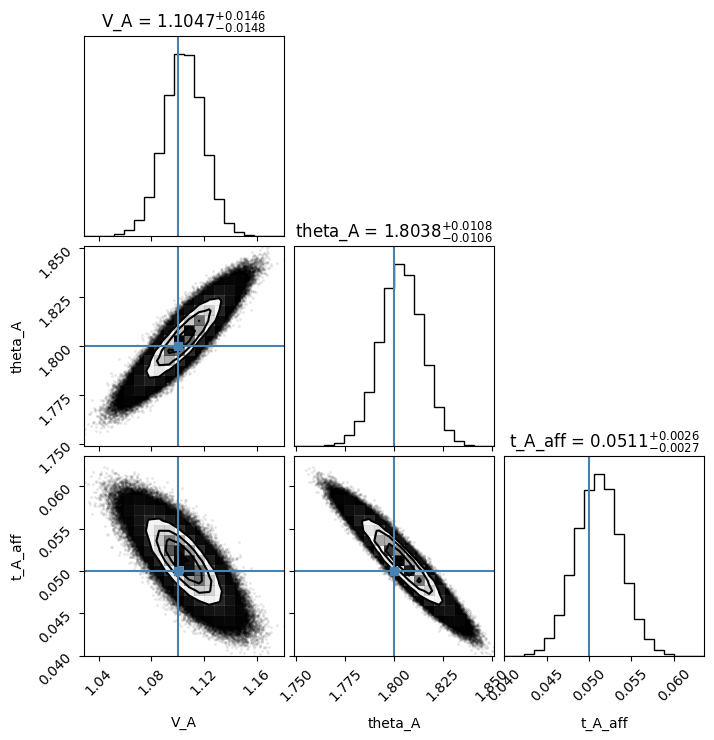

In [13]:
import corner
vp_samples = vp.sample(int(1e6))[0]
V_A_samp = vp_samples[:,0]
theta_A_samp = vp_samples[:,1]
t_A_aff_samp = vp_samples[:,2]

combined_samples = np.transpose(np.vstack((V_A_samp, theta_A_samp, t_A_aff_samp)))
param_labels = ['V_A', 'theta_A', 't_A_aff']
true_params = [V_A, theta_A, t_A_aff]
corner.corner (combined_samples, labels=param_labels, show_titles=True, title_fmt=".4f", truths=true_params  );


# simulate with vp mean params

In [14]:
V_A_samp_mean = np.mean(V_A_samp)
theta_A_samp_mean = np.mean(theta_A_samp)
t_A_aff_samp_mean = np.mean(t_A_aff_samp)

sim_results_samp_mean = Parallel(n_jobs=-1)(
            delayed(psiam_tied_data_gen_wrapper)(V_A_samp_mean, theta_A_samp_mean, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E, \
                                                  t_A_aff_samp_mean, t_E_aff, t_motor, L, t_stim_0, t_stim_tau, iter_num, N_print, dt)
            for iter_num in tqdm(range(N_sim))
        )


  0%|          | 448/500000 [00:00<02:38, 3161.28it/s]

In iter_num: 0, ABL: 60, ILD: -1.0, t_stim: 1.578157465313952


100%|██████████| 500000/500000 [04:49<00:00, 1729.97it/s]


# aborts distrn compare

In [15]:
bins = np.arange(0, 2, 0.01)
# original sim data
aborts_og = [res['rt'] for res in sim_results if res['rt'] < res['t_stim'] and res['rt'] > T_trunc]

# vp mean sim data 
aborts_samp_mean = [res['rt'] for res in sim_results_samp_mean if res['rt'] < res['t_stim'] and res['rt'] > T_trunc]


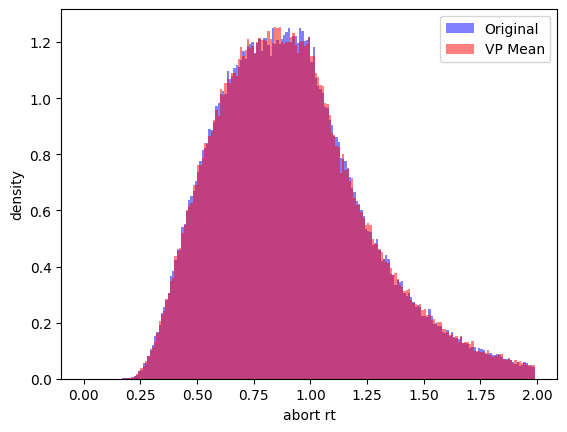

In [16]:
plt.hist(aborts_og, bins, alpha=0.5, label='Original', density=True, color='b')
plt.hist(aborts_samp_mean, bins, alpha=0.5, label='VP Mean', density=True, color='r')

plt.xlabel('abort rt'); plt.ylabel('density'); plt.legend();

# check PDF fit

In [17]:

def prob_hit_and_fix_survive(t, t_stim_0, t_stim_tau, V_A, theta_A, t_A_aff):
    if t < t_stim_0:
        fix_survive = 1
    else:
        fix_survive = np.exp(-(t - t_stim_0)/t_stim_tau)
    
    return rho_A_t_fn(t-t_A_aff, V_A, theta_A) * fix_survive
    
    


def pdf_aborts(t, t_stim_0, t_stim_tau, V_A, theta_A, T_trunc, t_A_aff, PDF_trunc_factor):
    """
    pdf of aborts with stim time
    """
    if t < T_trunc:
        return 0
    

    pdf_hit_and_fix_survive_truncated = prob_hit_and_fix_survive(t, t_stim_0, t_stim_tau, V_A, theta_A, t_A_aff) / PDF_trunc_factor
    return pdf_hit_and_fix_survive_truncated
    
    # if t < t_stim_0:
    #     fix_survive = 1
    # else:
    #     fix_survive = np.exp(-(t - t_stim_0)/t_stim_tau)

    # return pdf_hit_and_fix_survive_truncated

    # pdf_fix_ended_and_censored = (1 - fix_survive)*( 1 - (cum_A_t_fn(t, V_A, theta_A)/PDF_trunc_factor) )

    # return pdf_hit_and_fix_survive_truncated + pdf_fix_ended_and_censored




# pdf fit - vp params and vp data

In [18]:
pdf_trunc_factor = quad(prob_hit_and_fix_survive, T_trunc, 10, args=(t_stim_0, t_stim_tau, V_A_samp_mean, theta_A_samp_mean, t_A_aff_samp_mean))[0]

t_pts = bins[:-1] + np.diff(bins)/2
theory_pdf_aborts = [pdf_aborts(t, t_stim_0, t_stim_tau, V_A_samp_mean, theta_A_samp_mean, T_trunc, t_A_aff_samp_mean, pdf_trunc_factor) for t in t_pts]


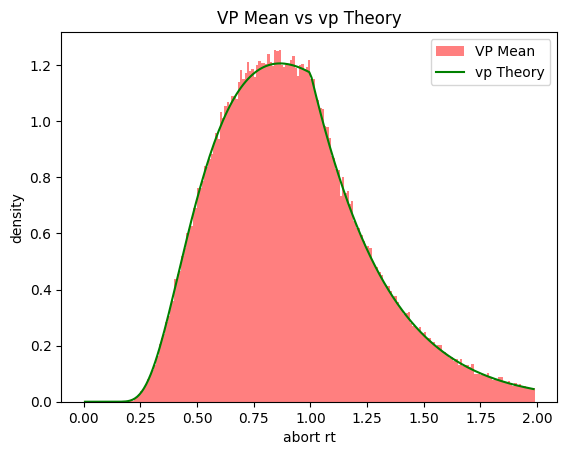

In [19]:
plt.hist(aborts_samp_mean, bins, alpha=0.5, label='VP Mean', density=True, color='r')
plt.plot(t_pts, theory_pdf_aborts, label='vp Theory', color='g')
plt.xlabel('abort rt'); plt.ylabel('density'); plt.legend(); plt.title('VP Mean vs vp Theory');

# pdf fit og params - og data

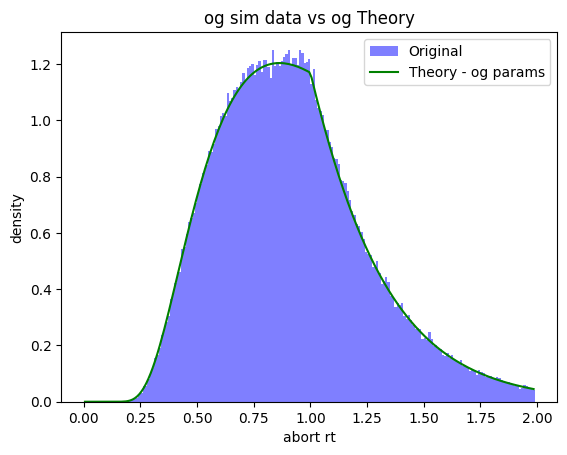

In [20]:
plt.hist(aborts_og, bins, alpha=0.5, label='Original', density=True, color='b')
t_pts = bins[:-1] + np.diff(bins)/2
pdf_trunc_factor = quad(prob_hit_and_fix_survive, T_trunc, 10, args=(t_stim_0, t_stim_tau, V_A, theta_A, t_A_aff))[0]
pdf_theory = [pdf_aborts(t, t_stim_0, t_stim_tau, V_A, theta_A, T_trunc, t_A_aff, pdf_trunc_factor) for t in t_pts]

plt.plot(t_pts, pdf_theory, label='Theory - og params', color='g')
plt.xlabel('abort rt'); plt.ylabel('density'); plt.legend(); plt.title('og sim data vs og Theory');



# pdf fit - vp params on og data

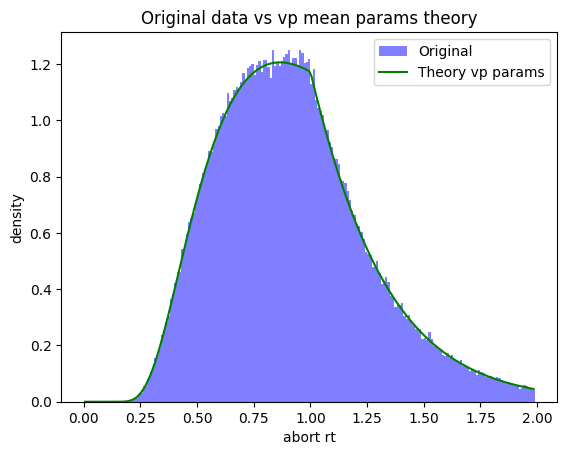

In [21]:
plt.hist(aborts_og, bins, alpha=0.5, label='Original', density=True, color='b')

theory_pdf_aborts = [pdf_aborts(t, t_stim_0, t_stim_tau, V_A_samp_mean, theta_A_samp_mean, T_trunc, t_A_aff_samp_mean, pdf_trunc_factor) for t in t_pts]

plt.plot(t_pts, theory_pdf_aborts, label='Theory vp params', color='g')
plt.xlabel('abort rt'); plt.ylabel('density'); plt.legend(); plt.title('Original data vs vp mean params theory');